In [22]:
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter
from skimage import data
from skimage.feature import register_translation
from skimage.feature.register_translation import _upsampled_dft
from scipy.ndimage import fourier_shift
from scipy.ndimage.interpolation import shift

import cv2
import numpy as np
from PIL import Image
import sys
sys.path.append('../..')
from core import *
from utils import *

t_elapsed = 0

In [23]:
def show_img(img1, img2):
    fig = plt.figure(figsize=(8, 3))
    ax1 = plt.subplot(1, 3, 1)
    ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
    ax3 = plt.subplot(1, 3, 3)

    ax1.imshow(img1, cmap='gray')
    ax1.set_axis_off()
    ax1.set_title('Reference image')

    ax2.imshow(img2.real, cmap='gray')
    ax2.set_axis_off()
    ax2.set_title('NIR image')

    # Show the output of a cross-correlation to show what the algorithm is
    # doing behind the scenes
    image_product = np.fft.fft2(img1) * np.fft.fft2(img2).conj()
    cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
    ax3.imshow(cc_image.real)
    ax3.set_axis_off()
    ax3.set_title("Cross-correlation")

    plt.show()

### open images and color map lookup table

In [24]:
cmap = np.genfromtxt('../../cmap.csv', delimiter=',')
#kernel = np.ones((5,5),np.float32)/25
img = cv2.imread('../../../../../Downloads/RGB.png')
img = cv2.GaussianBlur(img,(5,5),0)
#print(img.shape)
[b, g, r] = channelSplit(img)
r = np.asarray(r.T[0]).astype(float).T
b = np.asarray(b.T[0]).astype(float).T
g = np.asarray(g.T[0]).astype(float).T

img2 = cv2.imread('../../../../../Downloads/NGB.png')
img2 = cv2.GaussianBlur(img2,(5,5),0)
#print(img.shape)
[b2, g2, r2] = channelSplit(img2)
r2 = np.asarray(r2.T[0]).astype(float).T
b2= np.asarray(b2.T[0]).astype(float).T
g2 = np.asarray(g2.T[0]).astype(float).T

### find offset between images

In [25]:
Rimg = r #red pixel set from pi camera
NIRoff = b2 #NIR pixel set from NOIR camera

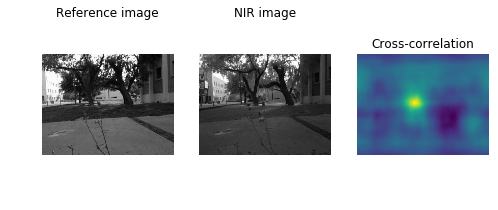

time = 0.16832575892351542
Detected pixel offset (y, x): [-12. -58.]


In [26]:
show_img(Rimg, NIRoff)
t_new = perf_counter()
shiftXY, error, diffphase = register_translation(Rimg, NIRoff)
t_elapsed += perf_counter() - t_new
print("time = "+ str(t_elapsed))
print("Detected pixel offset (y, x): {}".format(shiftXY))


### Shift NIR image

#### Iteration 1

In [27]:
t_new = perf_counter()
NIRimg = shift(NIRoff, np.array(shiftXY))
t_elapsed += perf_counter() - t_new
print("time = "+ str(t_elapsed))

time = 0.22746462752689922


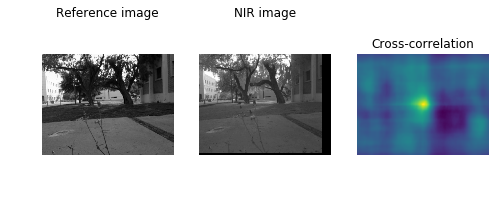

Detected pixel offset (y, x): [ 0.  0.]


In [19]:
show_img(Rimg, NIRimg)
shiftXY, error, diffphase = register_translation(Rimg, NIRimg)
print("Detected pixel offset (y, x): {}".format(shiftXY))

#### Iteration 2 -- should be doing subpixel version

In [20]:
NIRimg = shift(NIRimg, np.array(shiftXY))

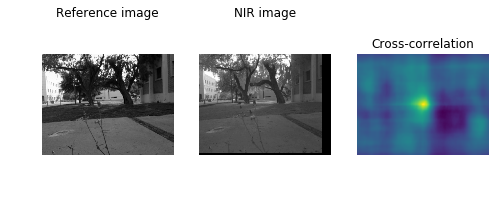

Detected pixel offset (y, x): [ 0.  0.]


In [33]:
show_img(Rimg, NIRimg)

shiftXY, error, diffphase = register_translation(Rimg, NIRimg)
print("Detected pixel offset (y, x): {}".format(shiftXY))

3.0489473166932695